<a href="https://colab.research.google.com/github/p16111121/fcc_cat_dgg_test/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [90]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                            directory=train_dir,
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory= PATH, classes=['test'],
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode = None,
                                                        shuffle = False
                                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [92]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

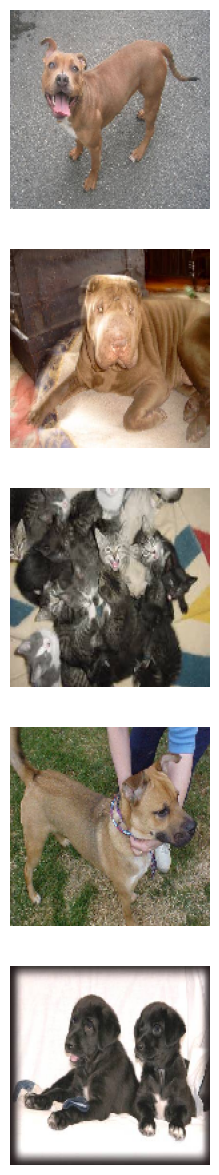

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [93]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode = 'nearest')


Found 2000 images belonging to 2 classes.


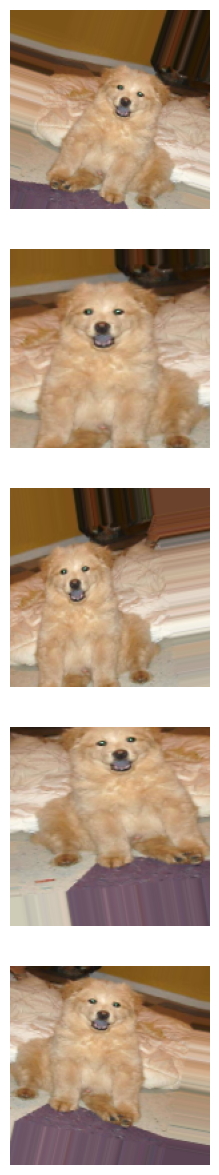

In [95]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [96]:
# 7
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully Connected Layers
    Dense(512, activation='relu'),
    Dropout(0.2),  # Prevent overfitting

    # Output Layer
    Dense(1 , activation='sigmoid')  # Use 'softmax' for multi-class classification

])

# Compile the model
model.compile(
    optimizer= 'adam',                 # Adam optimizer
    loss='binary_crossentropy',       # Binary Cross Entropy loss for binary classification
    metrics=['accuracy']              # Track accuracy during training
)

# Summary of the model
model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,813,889 (25.99 MB)

 Trainable params: 6,812,929 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [97]:
# 8
history = model.fit(
    train_data_gen,

    callbacks = [learning_rate_reduction],
    epochs=epochs,
    validation_data=val_data_gen,

)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 212s 12s/step - accuracy: 0.5135 - loss: 6.5949 - val_accuracy: 0.5000 - val_loss: 0.7372 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 203s 12s/step - accuracy: 0.5365 - loss: 0.8588 - val_accuracy: 0.4940 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5563 - loss: 0.7657 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 261s 12s/step - accuracy: 0.5567 - loss: 0.7635 - val_accuracy: 0.4650 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 260s 12s/step - accuracy: 0.5930 - loss: 0.7057 - val_accuracy: 0.5040 - val_loss: 0.6980 - learning_rate: 5.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 0.6157 - loss: 0.6672 - val_accuracy: 0.4960 - val_loss: 0.7226 - learning_rate: 5.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 199s 12s/step - accuracy: 0.6077 - loss: 0.6593 - val_a

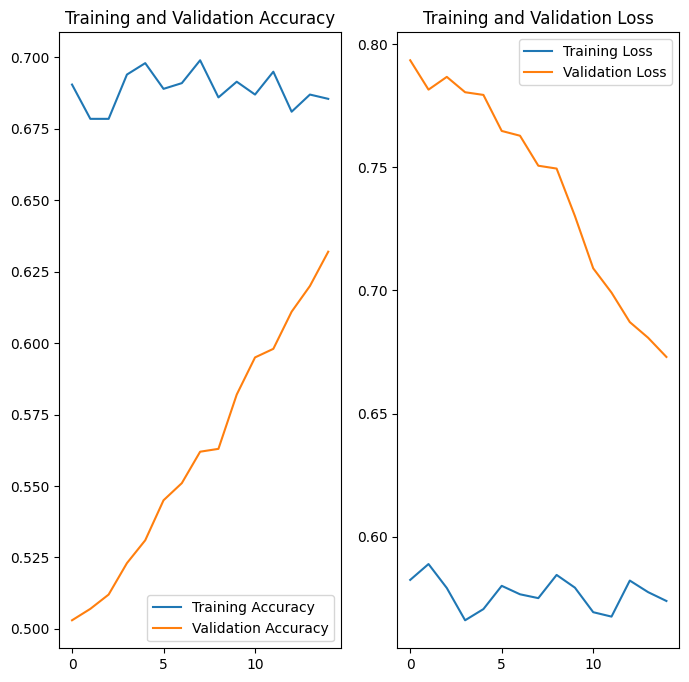

In [77]:
 # 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [82]:
# 10
probabilities = model.predict(test_data_gen)
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.75253576 0.24746425]
 [0.90013814 0.0998618 ]
 [0.7974331  0.20256695]
 [0.39248982 0.6075101 ]
 [0.72775775 0.27224228]
 [0.8474176  0.1525824 ]
 [0.4050719  0.59492815]
 [0.893209   0.10679097]
 [0.5752587  0.42474133]
 [0.73852354 0.2614765 ]
 [0.6726991  0.32730082]
 [0.61875695 0.38124302]
 [0.8388423  0.16115773]
 [0.7776155  0.22238453]
 [0.7616608  0.23833917]
 [0.7093225  0.29067752]
 [0.7425212  0.25747883]
 [0.66829056 0.33170938]
 [0.59303415 0.4069659 ]
 [0.68737704 0.31262293]
 [0.89995867 0.10004138]
 [0.51540136 0.4845986 ]
 [0.7293019  0.2706981 ]
 [0.6513062  0.34869373]
 [0.5562315  0.4437685 ]
 [0.5658321  0.43416795]
 [0.29885417 0.7011458 ]
 [0.8026142  0.19738574]
 [0.8177118  0.18228814]
 [0.84242153 0.15757842]
 [0.7584547  0.24154529]
 [0.90512675 0.09487325]
 [0.57843816 0.4215618 ]
 [0.02637468 0.97362536]
 [0.8206249  0.17937502]
 [0.52185136 0.4781487 ]
 [0.06321879 0.9367813 ]
 [0.68624157 0.31375843]
 [0.6295996  0

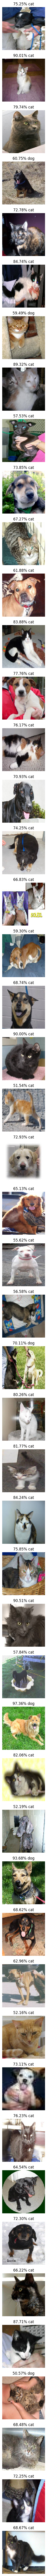

In [88]:
test_images = next(test_data_gen)
plotImages(test_images,probabilities)

In [89]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 56.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
